In [ ]:
# !pip install matplotlib opencv-python albumentations tqdm

In [ ]:
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [1]:
!pip install carvekit



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os

# os.

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

import segmentation_models_pytorch as smp

import torchvision
from torchvision import datasets, models, transforms

import albumentations as albu
import matplotlib.pyplot as plt
import numpy as np
import os

/usr/local/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
from helper.metrics import IoU, Accuracy, Fscore, Recall, Precision, DiceLoss
from helper.train import BaseDataset, VisualizeDataset, VisualizeResult, TestEpoch, TrainEpoch

ModuleNotFoundError: No module named 'helper'

In [2]:
LR = 0.0001
DLR_STEPS = 7
DLR_GAMMA = 0.1
EPOCHS = 20
MODEL_PATH = '../../saved_models/MobileNetV3Encoder_UnetPlusPlus.pth'
DATA_DIR = '../../dataset/TrayDataset/'
BATCH = 8
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [7]:
!ls

jupyter_config	object_segmentation.ipynb


In [3]:
import torch
from carvekit.api.high import HiInterface
from PIL import Image
import cv2

from carvekit.api.interface import Interface
from carvekit.ml.wrap.fba_matting import FBAMatting
from carvekit.ml.wrap.tracer_b7 import TracerUniversalB7
from carvekit.pipelines.postprocessing import MattingMethod
from carvekit.pipelines.preprocessing import PreprocessingStub
from carvekit.trimap.generator import TrimapGenerator

# Check doc strings for more information
fba_flag = False
interface = None
if True :
    seg_net = TracerUniversalB7(device='cuda' if torch.cuda.is_available() else 'cpu',
                  batch_size=16)
    
    fba = FBAMatting(device='cuda' if torch.cuda.is_available() else 'cpu',
                     input_tensor_size=2048,
                     batch_size=1)
    
    trimap = TrimapGenerator()
    
    preprocessing = PreprocessingStub()
    
    postprocessing = MattingMethod(matting_module=(fba if fba_flag else None),
                                   trimap_generator=trimap,
                                   device='cuda' if torch.cuda.is_available() else 'cpu')
    
    interface = Interface(pre_pipe=preprocessing,
                          post_pipe=postprocessing,
                          seg_pipe=seg_net)

    HiInterface

    # interface = Interface(pre_pipe=preprocessing,
    #                   post_pipe=postprocessing,
    #                   seg_pipe=seg_net)

# else:
#     interface = HiInterface(object_type="hairs-like",  # Can be "object" or "hairs-like".
#                             batch_size_seg=5,
#                             batch_size_matting=1,
#                             device='cuda' if torch.cuda.is_available() else 'cpu',
#                             seg_mask_size=640,  # Use 640 for Tracer B7 and 320 for U2Net
#                             matting_mask_size=2048,
#                             trimap_prob_threshold=231,
#                             trimap_dilation=30,
#                             trimap_erosion_iters=5,
#                             fp16=False)


ROOT_PATH = '/workspace/NN'
DATA_PATCH = os.path.join(ROOT_PATH, 'data')

files = [i for i in [ os.path.join(DATA_PATCH, 'sirius_data', f'{i}.jpg') for i in range(17)] if os.path.isfile(i)]
img_count = len(files)
print(*files)
images_without_background = interface(files)

for ind in range(len(images_without_background)):
    img = images_without_background[ind]
    img = np.array(img)
    base_image = cv2.imread(files[ind])
    base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGBA)
    mask = (img[:,:,3] == 0).reshape((img.shape[0], img.shape[1]))
    mask = np.concatenate((mask, mask, mask, mask), axis=2)
    color = np.concatenate([np.random.random(3) * 255, [0.35]])
    img[mask] = (base_image[mask] + color)
    img = Image.fromarray(((img).astype('uint8')), mode='RGBA',)
    images_without_background[ind] = img


# fba = FBAMatting(device='cpu',
#                  input_tensor_size=2048,
#                  batch_size=1)

# cat_wo_bg = images_without_background[0]
[images_without_background[i].save(os.path.join(DATA_PATCH, 'res', f'{i}.png')) for i in range(img_count)]
images_without_background




#opens an image:
# im = Image.open("1_tree.jpg")
#creates a new empty image, RGB mode, and size 400 by 400.
new_im = Image.new('RGBA', (246 * 4, 328* 4))

#Here I resize my opened image, so it is no bigger than 100,100
#
#Iterate through a 4 by 4 grid with 100 spacing, to place my image
for i in range(0, 4,1):
    for j in range(0, 4,1):
        #I change brightness of the images, just to emphasise they are unique copies.
        # im=Image.eval(im,lambda x: x+(i+j)/30)
        #paste the image at location i,j:
        im = images_without_background[i * 4 + j]
        im.thumbnail((246,328))
        new_im.paste(im, (i*246,j * 328))

new_im.show()



/usr/local/lib/python3.11/site-packages/carvekit/ml/wrap/tracer_b7.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(model_path, map_location=self.device), str

/workspace/NN/data/sirius_data/0.jpg /workspace/NN/data/sirius_data/1.jpg /workspace/NN/data/sirius_data/2.jpg /workspace/NN/data/sirius_data/4.jpg /workspace/NN/data/sirius_data/5.jpg /workspace/NN/data/sirius_data/6.jpg /workspace/NN/data/sirius_data/7.jpg /workspace/NN/data/sirius_data/8.jpg /workspace/NN/data/sirius_data/9.jpg /workspace/NN/data/sirius_data/10.jpg /workspace/NN/data/sirius_data/11.jpg /workspace/NN/data/sirius_data/12.jpg /workspace/NN/data/sirius_data/13.jpg /workspace/NN/data/sirius_data/14.jpg /workspace/NN/data/sirius_data/15.jpg /workspace/NN/data/sirius_data/16.jpg


TypeError: 'NoneType' object is not callable

In [ ]:
  # base_image = cv2.imread(os.path.join(args.input_path, im_name))
  #       base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGBA)

In [34]:

import torch
from carvekit.web.schemas.config import MLConfig
from carvekit.web.utils.init_utils import init_interface

SHOW_FULLSIZE = False #@param {type:"boolean"}
PREPROCESSING_METHOD = "none" #@param ["stub", "none"]
SEGMENTATION_NETWORK = "basnet" #@param ["u2net", "deeplabv3", "basnet", "tracer_b7"]
POSTPROCESSING_METHOD = "fba" #@param ["fba", "none"]
SEGMENTATION_MASK_SIZE = 320 #@param ["640", "320"] {type:"raw", allow-input: true}
TRIMAP_DILATION = 30 #@param {type:"integer"}
TRIMAP_EROSION = 5 #@param {type:"integer"}
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


config = MLConfig(segmentation_network=SEGMENTATION_NETWORK,
                  preprocessing_method=PREPROCESSING_METHOD,
                  postprocessing_method=POSTPROCESSING_METHOD,
                  seg_mask_size=SEGMENTATION_MASK_SIZE,
                  trimap_dilation=TRIMAP_DILATION,
                  trimap_erosion=TRIMAP_EROSION,
                  device=DEVICE)


interface = init_interface(config)

/workspace/NN/data/sirius_data/0.jpg /workspace/NN/data/sirius_data/1.jpg /workspace/NN/data/sirius_data/2.jpg /workspace/NN/data/sirius_data/4.jpg /workspace/NN/data/sirius_data/5.jpg /workspace/NN/data/sirius_data/6.jpg /workspace/NN/data/sirius_data/7.jpg /workspace/NN/data/sirius_data/8.jpg /workspace/NN/data/sirius_data/9.jpg /workspace/NN/data/sirius_data/10.jpg /workspace/NN/data/sirius_data/11.jpg /workspace/NN/data/sirius_data/12.jpg /workspace/NN/data/sirius_data/13.jpg /workspace/NN/data/sirius_data/14.jpg /workspace/NN/data/sirius_data/15.jpg /workspace/NN/data/sirius_data/16.jpg


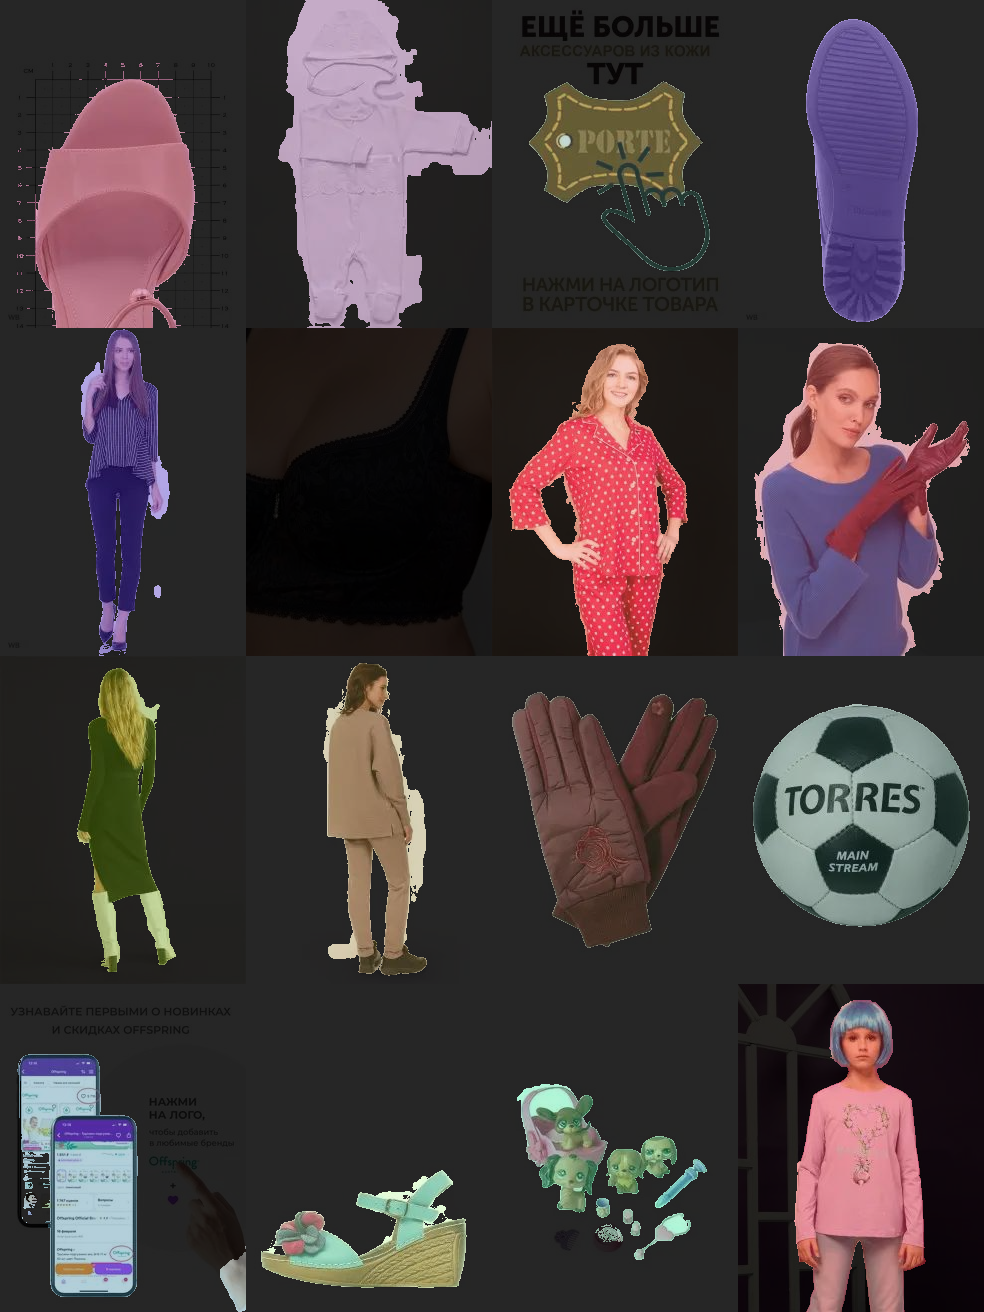

In [35]:
    
ROOT_PATH = '/workspace/NN'
DATA_PATCH = os.path.join(ROOT_PATH, 'data')

files = [i for i in [ os.path.join(DATA_PATCH, 'sirius_data', f'{i}.jpg') for i in range(17)] if os.path.isfile(i)]
img_count = len(files)
print(*files)
images_without_background = interface(files)
# fba = FBAMatting(device='cpu',
#                  input_tensor_size=2048,
#                  batch_size=1)

# cat_wo_bg = images_without_background[0]
[images_without_background[i].save(os.path.join(DATA_PATCH, 'res', f'{i}.png')) for i in range(img_count)]
images_without_background


for ind in range(len(images_without_background)):
    img = images_without_background[ind]
    img = np.array(img)
    base_image = cv2.imread(files[ind])
    base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGBA)
    mask = (img[:,:,3] == 0).reshape((img.shape[0], img.shape[1], 1))
    mask = np.concatenate((mask, mask, mask, mask), axis=2)
    color = np.concatenate([[0, 0, 0], [255]]).reshape((1, 1, 4))
    color = np.concatenate([color ]* img.shape[0], axis=0)
    color = np.concatenate([color ]* img.shape[1], axis=1)
    # print(color.shape)
    # img[:, :, 3] = 1
    img[mask] =  (base_image[mask] * 0.15 + color[mask] * 0.85)

    color2 = np.concatenate([np.random.random(3) * 255, [1]]).reshape((1, 1, 4))
    color2 = np.concatenate([color2 ]* img.shape[0], axis=0)
    color2 = np.concatenate([color2 ]* img.shape[1], axis=1)
    # print(color.shape)
    img[~mask] = (base_image[~mask] * 0.65 + color2[~mask] * 0.35)
    img[:, :, 3] = 255
    img = Image.fromarray(((img).astype('uint8')), mode='RGBA',)
    images_without_background[ind] = img

#opens an image:
# im = Image.open("1_tree.jpg")
#creates a new empty image, RGB mode, and size 400 by 400.
new_im = Image.new('RGBA', (246 * 4, 328* 4))

#Here I resize my opened image, so it is no bigger than 100,100
#
#Iterate through a 4 by 4 grid with 100 spacing, to place my image
for i in range(0, 4,1):
    for j in range(0, 4,1):
        #I change brightness of the images, just to emphasise they are unique copies.
        # im=Image.eval(im,lambda x: x+(i+j)/30)
        #paste the image at location i,j:
        im = images_without_background[i * 4 + j]
        im.thumbnail((246,328))
        new_im.paste(im, (i*246,j * 328))

new_im.show()
